<a href="https://colab.research.google.com/github/aycaaozturk/Nail-Melanoma-Project/blob/main/ResNet18_Medical_Image_Classification_Nails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verify the data structure

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Define Data Transformations

In [ ]:

# preprocessing (augmentation)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([  # Using 'val' as a validation set; rename to 'test' if preferred
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

 Set Data Directory and Create Data Loaders

In [ ]:
#data_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset'

data_dir = '/content/drive/My Drive/binary classification'


In [ ]:
# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])  # Use 'val' key for transformations, as it's defined in data_transforms
}

# Create dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"Dataset sizes: {dataset_sizes}")

class_names = image_datasets['train'].classes
print(f"Class names: {class_names}")  # Should output ['melanoma', 'normal']

Dataset sizes: {'train': 2959, 'val': 845}
Class names: ['melanoma', 'non_melanoma']


Load and Modify Pre-trained Model

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 16.4MB/s]


In [ ]:
# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the final layer to match the number of classes (2 in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Output layer for 2 classes

# Ensure the final layer parameters are trainable
for param in model.fc.parameters():
    param.requires_grad = True

Define Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


Move Model to GPU if Available

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Using device: cuda:0


Training Loop

In [ ]:
import time
import matplotlib.pyplot as plt

num_epochs = 10

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Record metrics
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds\n')

print("Training complete!")

Epoch 1/10
----------
Train Loss: 0.4175 Acc: 0.8418
Val Loss: 0.4059 Acc: 0.8320
Epoch 1 completed in 300.82 seconds

Epoch 2/10
----------
Train Loss: 0.3486 Acc: 0.8591
Val Loss: 0.3267 Acc: 0.8982
Epoch 2 completed in 9.83 seconds

Epoch 3/10
----------
Train Loss: 0.3232 Acc: 0.8692
Val Loss: 0.3298 Acc: 0.8426
Epoch 3 completed in 9.75 seconds

Epoch 4/10
----------
Train Loss: 0.3094 Acc: 0.8689
Val Loss: 0.2931 Acc: 0.8592
Epoch 4 completed in 9.54 seconds

Epoch 5/10
----------
Train Loss: 0.2933 Acc: 0.8807
Val Loss: 0.2503 Acc: 0.8876
Epoch 5 completed in 9.90 seconds

Epoch 6/10
----------
Train Loss: 0.2779 Acc: 0.8871
Val Loss: 0.2438 Acc: 0.8876
Epoch 6 completed in 9.83 seconds

Epoch 7/10
----------
Train Loss: 0.2714 Acc: 0.8881
Val Loss: 0.2403 Acc: 0.8876
Epoch 7 completed in 9.94 seconds

Epoch 8/10
----------
Train Loss: 0.2654 Acc: 0.8962
Val Loss: 0.2332 Acc: 0.8888
Epoch 8 completed in 9.51 seconds

Epoch 9/10
----------
Train Loss: 0.2652 Acc: 0.8915
Val Loss:

Plotting the Graphs

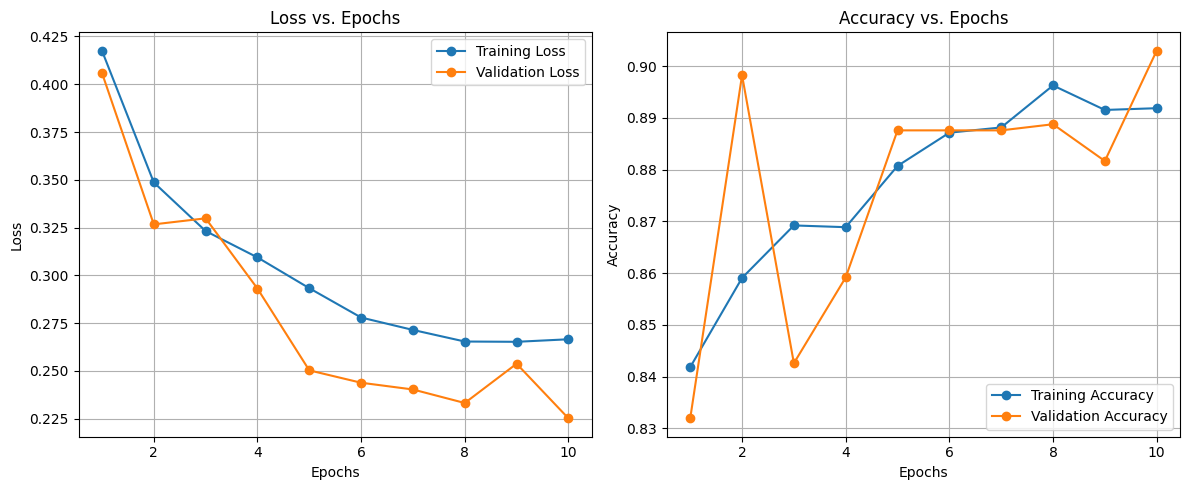

In [ ]:
# Plotting Loss and Accuracy

# Set up the plot
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

print("Training complete!")


Epoch 1/10
----------
Train Loss: 0.2698 Acc: 0.8875
Val Loss: 0.2376 Acc: 0.9136

Epoch 2/10
----------
Train Loss: 0.2600 Acc: 0.8969
Val Loss: 0.2216 Acc: 0.8923

Epoch 3/10
----------
Train Loss: 0.2574 Acc: 0.8935
Val Loss: 0.2169 Acc: 0.8959

Epoch 4/10
----------
Train Loss: 0.2487 Acc: 0.8969
Val Loss: 0.2401 Acc: 0.8899

Epoch 5/10
----------
Train Loss: 0.2571 Acc: 0.8946
Val Loss: 0.2138 Acc: 0.9030

Epoch 6/10
----------
Train Loss: 0.2536 Acc: 0.8973
Val Loss: 0.2108 Acc: 0.8994

Epoch 7/10
----------
Train Loss: 0.2460 Acc: 0.8986
Val Loss: 0.2056 Acc: 0.9065

Epoch 8/10
----------
Train Loss: 0.2609 Acc: 0.8956
Val Loss: 0.2171 Acc: 0.9160

Epoch 9/10
----------
Train Loss: 0.2552 Acc: 0.8979
Val Loss: 0.2106 Acc: 0.8959

Epoch 10/10
----------
Train Loss: 0.2614 Acc: 0.8990
Val Loss: 0.2451 Acc: 0.8828

Training complete!


Conf Matrix and Metrics

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Put the model in evaluation mode
model.eval()

all_labels = []
all_preds = []

# Disable gradient calculation (for speed and memory)
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


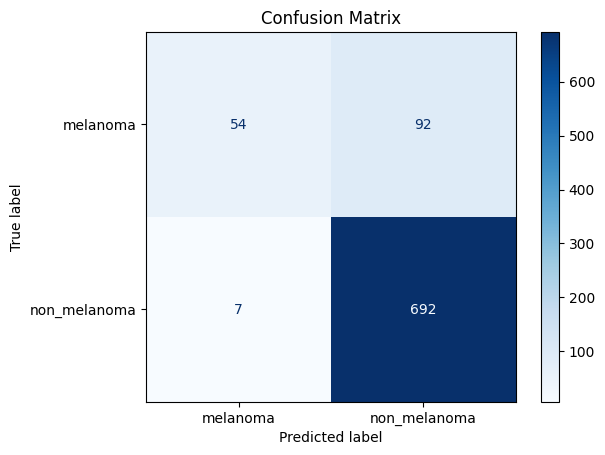

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.8828
Precision: 0.8831
Recall:    0.8828
F1 Score:  0.8621


In [ ]:
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

    melanoma     0.8852    0.3699    0.5217       146
non_melanoma     0.8827    0.9900    0.9332       699

    accuracy                         0.8828       845
   macro avg     0.8839    0.6799    0.7275       845
weighted avg     0.8831    0.8828    0.8621       845



Save the Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/resnet18_classification_model.pth')
print("Model saved to Google Drive.")

Model saved to Google Drive.


In [ ]:
# Function to load the model
def load_model(model_path, num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # Change the model path to the correct file name.
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model
# Load the saved model
# This should match the file name used during saving in ipython-input-19-2402abca7815.
model_path = '/content/drive/MyDrive/resnet18_classification_model.pth'
model = load_model(model_path, num_classes=2)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/resnet18_classification_model.pth'

Classification on Unseen Image

The predicted class is: melanoma


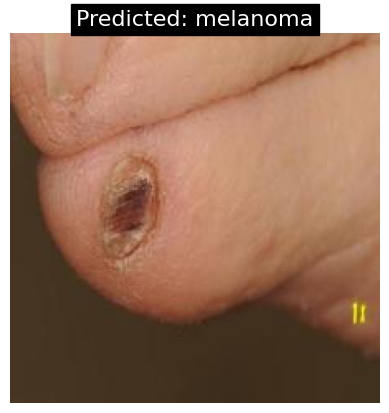

In [ ]:
# Function to predict the class of an image
def predict_image(image_path, model, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Create a mini-batch as expected by the model

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class_name = class_names[predicted_class.item()]

    return image, predicted_class_name

# Example usage:
# Replace 'test_image.jpg' with the path to your unseen image.
# If the image is in Google Drive, ensure to provide the correct path.
test_image_path = '/content/test_image1.jpg'  # Update this path

# Check if the test image exists
if os.path.exists(test_image_path):
    image, predicted_class_name = predict_image(test_image_path, model, class_names)
    print(f'The predicted class is: {predicted_class_name}')

    # Display the image with the predicted class name
    image_np = np.array(image)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class_name}', fontsize=16, color='white', backgroundcolor='black')
    plt.show()
else:
    print(f"Test image not found at {test_image_path}. Please upload an image to the specified path.")
